# RBM (Restrictive Boltzmann Machine)

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.

> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

### Simple RBM
2 passes are performed:
- forward pass: the input to the visible layer is the input image x
- backward pass: the input the hidden layer is the probability of obtaining x with the configuration of the input features

The objective is to obtain the optimal values for the hyperparameters (weight matrix, biases) so that the reconstruction error would be minimum. SGD is used to minimize the reconstruction error and obtain a more accurate reconstruction of the input, by updating the hyperparameters after visiting each instance. (online training)

The reconstruction error is computed as the difference between the pixel-wise mean-square error of the inputs to the visible layer (original image) and the output of the reconstructed image. The mean of the reconstruction errors of each training instance represents the training loss.

### Gibbs Sampling
The learning process consists of 2 phases:
- Gibbs sampling: first, the input (v) data is sent through the visible layer (forward pass), then the states of the neurons in the hidden layer are computed (h). Based on the obtained hidden layer values, it predicts the new input values for the visible layer (backward pass).
- Contrastive Divergence: update weights based on the inputs to visible layers and the activation probabilities for the hidden layers.

To find the optimal weight W, which minimizes the energy function E (cost function), we use **SGD**(Stochastic Gradient Descent) algorithm. For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient.
Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction

### Energy based model
Computes the free energy for the initial input to the visible layer and the reconstructed input, then it defines the loss as the absolute difference between these energy values.
> **Free energy** is the energy that a single configuration would need in order to
    have the same probability as all configurations containing v

This approach also uses SGD to minimize the energy loss, which represents the difference between the free energy of the input x and the reconstructed input v.


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import tensorflow_datasets as tfds
import cv2
from PIL import Image
import os
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

In [3]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


## Load and preprocess the data

The model is trained and evaluated on the Lost and Found dataset, which contains over 2000 images in total, obtained from multiple video sequences. Each image has an associated segmentation mask for all classes of objects and one for distinguishing the road surface.

Save the data

In [4]:
def save_img(img_arr, file_name):
    img_arr = img_arr.astype(np.uint8)
    if img_arr.ndim == 3 and img_arr.shape[2] == 1:
        img_arr = np.squeeze(img_arr, axis=2)
    img = Image.fromarray(img_arr)
    img.save(file_name)


def save_dataset(dataset, directory):
    nr_images = dataset.shape[0]
    for i in range(nr_images):
        save_img(dataset[i], directory + "/{}.jpeg".format(i))

Download the dataset

In [5]:
def download_data():
    (lost_and_found_train_ds, lost_and_found_test_ds), info = tfds.load(
        'lost_and_found/semantic_segmentation',
        split=['train', 'test'],
        batch_size=-1,
        with_info=True)

    x_train_img = lost_and_found_train_ds['image_left']
    x_train_mask = lost_and_found_train_ds['segmentation_label']
    print("Downloaded ", len(x_train_img), " train images")

    x_test_img = lost_and_found_test_ds['image_left']
    x_test_mask = lost_and_found_test_ds['segmentation_label']
    print("Downloaded ", len(x_test_img), " test images")

    # lost_and_found_train_df = tfds.as_dataframe(lost_and_found_train_ds.take(train_size), info)
    # x_train_img = lost_and_found_train_df['image_left'].to_numpy()
    # x_train_mask = lost_and_found_train_df['segmentation_label'].to_numpy()
    #
    # lost_and_found_test_df = tfds.as_dataframe(lost_and_found_test_ds.take(test_size), info)
    # x_test_img = lost_and_found_test_df['image_left'].to_numpy()
    # x_test_mask = lost_and_found_test_df['segmentation_label'].to_numpy()

    return (x_train_img, x_train_mask), (x_test_img, x_test_mask)

## Loading the data

In [6]:
def load_np_dataset_from_dir(directory, img_size, color_mode='rgb'):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode=color_mode,
        batch_size=None,
        image_size=img_size,
        shuffle=False
    )
    total_size = len(ds.file_paths)
    print("Read ", total_size, " images in total from directory: ", directory)

    return ds


def load_saved_dataset(directory, img_size):
    x_train_img = load_np_dataset_from_dir(directory=directory + "/train/image",
                                           img_size=img_size,
                                           color_mode='rgb')
    x_train_mask = load_np_dataset_from_dir(directory=directory + "/train/mask",
                                            img_size=img_size,
                                            color_mode='rgb')
    x_test_img = load_np_dataset_from_dir(directory=directory + "/test/image",
                                          img_size=img_size,
                                          color_mode='rgb')
    x_test_mask = load_np_dataset_from_dir(directory=directory + "/test/mask",
                                           img_size=img_size,
                                           color_mode='rgb')
    return (x_train_img, x_train_mask), (x_test_img, x_test_mask)

## Data Preprocessing

In [135]:
def normalize_img(img):
    max = tf.reduce_max(img)
    min = tf.reduce_min(img)
    range = tf.subtract(max, min)
    img = (img - min) / range
    return img


def preprocess_img(img, crop_size, patch_size, stride):
    img = tf.expand_dims(img, axis=0)
    # mean center and standardize the images
    img = tf.image.per_image_standardization(img)
    # normalize the images to the [0,1] range
    img = normalize_img(img)
    # crop the center of the image
    img = tf.image.crop_and_resize(img, boxes=[[0.75, 0.4, 0.8, 0.6]], box_indices=[0],
                                   crop_size=[crop_size, crop_size])
    patches = tf.image.extract_patches(img,
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, stride, stride, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patches = tf.reshape(patches, (-1, patch_size, patch_size, 3))
    return patches


def preprocess(ds, input_size, crop_size, patch_size, stride):
    ds = ds.take(input_size)
    ds = ds.map(lambda img: preprocess_img(img, crop_size=crop_size, patch_size=patch_size, stride=stride))
    return ds


def show_patches(patches, n=5):
    fig, axes = plt.subplots(n, n)
    for i in range(0, n):
        for j in range(0, n):
            axes[i][j].imshow(patches[i * n + j])

In [8]:
def load_input(img_size, directory=None):
    if directory is None or len(os.listdir(directory)) == 0:
        return download_data()

    # load the local dataset
    return load_saved_dataset(directory, img_size)

In [136]:
IMG_SIZE = (1024, 2048)
PATCH_SIZE = 50
CROP_SIZE = 500
STRIDE = 25
TRAIN_SIZE = 32
TEST_SIZE = 32

(train_img_ds, train_mask_ds), (test_img_ds, test_mask_ds) = load_input(img_size=IMG_SIZE,
                                                                        directory="datasets/lost_and_found")

tf.debugging.set_log_device_placement(True)
with tf.device(GPU_NAME):
    x_train = preprocess(train_img_ds, input_size=TRAIN_SIZE, crop_size=CROP_SIZE, patch_size=PATCH_SIZE, stride=STRIDE)
    x_test = preprocess(test_img_ds, input_size=TEST_SIZE, crop_size=CROP_SIZE, patch_size=PATCH_SIZE, stride=STRIDE)
tf.debugging.set_log_device_placement(False)

Found 1036 files belonging to 1 classes.
Read  1036  images in total from directory:  datasets/lost_and_found/train/image
Found 1036 files belonging to 1 classes.
Read  1036  images in total from directory:  datasets/lost_and_found/train/mask
Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  datasets/lost_and_found/test/image
Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  datasets/lost_and_found/test/mask


In [110]:
tf.print("Nr of training images: ", x_train.cardinality())
tf.print("Each image is transformed into multiple patches of dim: ", x_train.element_spec)

Nr of training images:  32
Each image is transformed into multiple patches of dim:  TensorSpec(shape=(361, 50, 50, 3), dtype=tf.float32, name=None)


In [11]:
tf.print("Nr of test images: ", x_test.cardinality())
tf.print("Each image is transformed into multiple patches of dim: ", x_test.element_spec)

Nr of test images:  32
Each image is transformed into multiple patches of dim:  TensorSpec(shape=(361, 50, 50, 3), dtype=tf.float32, name=None)


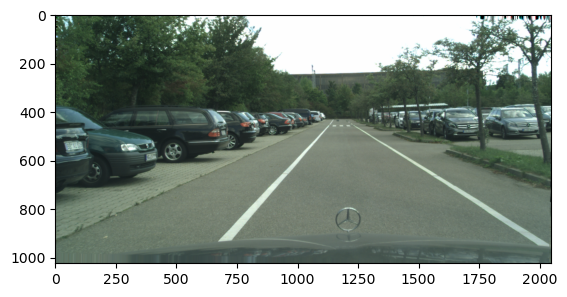

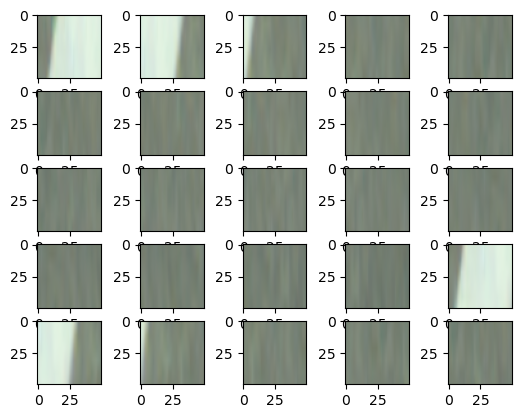

In [137]:
for img, patches in zip(train_img_ds, x_train):
    _ = plt.figure()
    plt.imshow(img / 255.0)
    show_patches(patches, n=5)
    break

# Build the model

In [156]:
class RBM:
    def __init__(self, P, H, k=1, W=None, hb=None, vb=None):
        """"
        :param P = patch size
        :param H = hidden layer size
        :param W (optional) = initial weights
        :param hb (optional) = initial hidden layer's bias
        :param vb (optional) = initial visible layer's bias
        :param k (optional) = nr of iterations in Gibbs sampling
        nv = nr of units in the visible layer = P * P * 3
        nh = nr of units in the hidden layer = H
        """""
        self.patch_size = P
        self.nv = P * P * 3
        self.nh = H
        self.k = k

        # initialize the weight matrix with uniform gaussian prob distribution
        self.W = W if W is not None else tf.Variable(tf.random.normal([self.nv, self.nh]))
        # bias for hidden layer (initialized with 0)
        self.hb = hb if hb is not None else tf.Variable(np.zeros(self.nh).astype(np.float32))
        # bias for visible layer (initialized with 0)
        self.vb = vb if vb is not None else tf.Variable(np.zeros(self.nv).astype(np.float32))

    def forward_pass(self, v):
        """
         forward pass: compute a sample hidden activation vector (h)
         input: flattened image vector
         output: probability of obtaining the input configuration
        """
        h = tf.matmul(v, self.W) + self.hb
        return tf.nn.sigmoid(h)

    def backward_pass(self, h):
        """
         backward pass: compute a sample visible activation vector (v)
         input: probability of obtaining the input configuration (activation of the visible layer)
         output: reconstructed input configuration
        """
        return tf.matmul(h, self.W, transpose_b=True) + self.vb

    def one_pass(self, v0):
        """
        Perform a forward and a backward pass to obtain the reconstructed input
        :param v0: flattened input image (with normalized values)
        :return:
        """
        h = self.forward_pass(v0)
        v1 = self.backward_pass(h)
        return v1

    def gibbs_sampling(self, v):
        v0 = v
        for i in range(self.k):
            h0 = self.forward_pass(v0)
            v0 = self.backward_pass(h0)
        return h0, v0

    def contrastive_divergence(self, v0, h0, v1, h1, lr):
        # v1 = self.bernoulli(v1)
        # positive weight gradient
        w_pos_grad = tf.matmul(v0, h0, transpose_a=True)
        # negative weight gradient
        w_neg_grad = tf.matmul(v1, h1, transpose_a=True)
        # compute the difference between these 2 gradients
        cd = tf.reduce_mean(w_pos_grad - w_neg_grad, 0)
        # update weights using CD
        self.W = self.W + lr * cd
        # update the biases
        self.vb = self.vb + lr * tf.reduce_sum(v0 - v1, 0)
        self.hb = self.hb + lr * tf.reduce_sum(h0 - h1, 0)

    def mean_squared_error(self, v0, v1):
        return tf.reduce_mean(tf.square(v0 - v1))

    def cross_entropy_loss(self, x, x1):
        # calculate the cross-entropy loss
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x1))

    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(tf.shape(p))))

    def reconstruction_error(self, v0, v1):
        """
        The smaller the reconstruction error of data is at the points with more probability distribution of training sample
        """
        loss = tf.math.abs(v0 - v1)
        loss = tf.math.multiply(loss, self.bernoulli(v1))
        return tf.reduce_sum(loss)

    def free_energy_gap(self, v):
        """
        Free energy is the energy that a single configuration would need in order to
        have the same probability as all configurations containing v.
        """
        # transform the visible bias to a column vector
        b = tf.reshape(self.vb, (self.nv, 1))
        visible_term = tf.matmul(v, b)
        # transform the result of the matrix multiplication back to a row vector
        visible_term = tf.reshape(visible_term, (1, -1))

        hidden_term = tf.nn.softplus(tf.matmul(v, self.W) + self.hb)
        hidden_term = tf.reduce_sum(hidden_term, axis=1)

        return tf.reduce_mean(- visible_term - hidden_term, axis=0)

    def energy_loss(self, v0, v1):
        """"
        Log-likelihood = approximation of the reconstructed data to the original data distribution
        """
        # calculate the difference between the energy values of v0 (original) and v1 (reconstructed) input
        v1 = self.bernoulli(v1)
        loss = tf.math.abs(self.free_energy_gap(v0) - self.free_energy_gap(v1))
        return loss

    def update(self, v0, lr, loss_fn):
        """
        SGD optimizer: used to find the optimal weights which minimize the energy function.
        :param x = input vector to the visible layer
        :param lr = learning rate
        :param loss_fn = the loss function to be used. Can be one of 'mean-squared-error', 'contrastive-divergence','cross-entropy-loss','free-energy-gap'
        """

        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

        with tf.GradientTape() as tape:
            tape.watch([self.W, self.hb, self.vb])
            # Gibbs sampling
            h0, v1 = self.gibbs_sampling(v0)
            h1 = self.forward_pass(v1)

            if loss_fn == 'contrastive-divergence':
                loss = self.reconstruction_error(v0, v1)
            if loss_fn == 'mean-squared-error':
                loss = self.mean_squared_error(v0, v1)
            elif loss_fn == 'cross-entropy-loss':
                loss = self.cross_entropy_loss(v0, v1)
            elif loss_fn == 'free-energy-gap':
                loss = self.energy_loss(v0, v1)

        if loss_fn == 'contrastive-divergence':
            # update weights and biases to minimize loss
            self.contrastive_divergence(v0, h0, v1, h1, lr)
        else:
            # minimize the loss function by calculating the gradient and updating the list of variables
            optimizer.minimize(loss, var_list=[self.W, self.hb, self.vb], tape=tape)

        return loss.numpy()

    def augment_image(self, img):
        # extract a smaller patch
        img = tf.image.random_crop(img, (self.patch_size, self.patch_size, 3))
        # flatten the pixels
        img = tf.reshape(img, [-1, self.nv])
        return img

    def fit(self, x, lr=0.001, epochs=15, loss_fn='mean-squared-error', patience=2, error_limit=1e-2):
        """"
        :param x: training data
        :param lr: learning rate
        :param epochs: nr of epochs to be trained on
        :param error_limit: the min change in the error
        :param patience: the nr of epochs to wait before stopping if the loss doesn't change
        :return: the train error

        Run gradient descent to find the optimal hyper-parameters for the model.
        """""
        training_loss = []
        prev_loss = 0
        patience_cnt = 0

        for epoch in range(0, epochs):
            loss_per_epoch = 0
            s = 0
            # shuffle the elements
            x = x.shuffle(1000)
            for instance in x:
                for patch in instance:
                    x0 = self.augment_image(patch)
                    # update the weight matrix and the visible bias & hidden bias
                    loss = self.update(x0, lr=lr, loss_fn=loss_fn)
                    loss_per_epoch += loss
                    s += 1
            loss_per_epoch /= s
            print('Epoch: ', epoch, ', train loss:', loss_per_epoch)

            if np.abs(loss_per_epoch - prev_loss) <= error_limit:
                patience_cnt += 1
                if patience_cnt > patience:
                    print("Early stop!")
                    break

            prev_loss = loss_per_epoch
            training_loss.append(loss_per_epoch)

        self.plot_fn(training_loss)
        return np.asarray(training_loss).mean()

    def save_model(self, filename):
        configs = {
            'nv': self.nv,
            'nh': self.nh,
            'k': self.k,
            'patch_size': self.patch_size,
            'W': self.W,
            'vb': self.vb,
            'hb': self.hb
        }
        tf.io.write_file(filename, configs)

    def load_model(self, filename):
        configs = tf.io.read_file(filename)
        self.nv = configs['nv']
        self.nh = configs['nh']

    def reconstruct(self, v0):
        """
        Represent a forward & backward pass through the network.
        Return the reconstructed image based on the previously learned weights.
        The input image is a 3D array, and the output preserves the shape of the input.
        """
        original_shape = v0.shape
        # reshape the input
        v0 = tf.reshape(v0, [-1, self.nv])
        # initial hidden prob vector based on the input v0
        v1 = self.one_pass(v0)
        # convert the output to the input's original shape
        v1 = tf.reshape(v1, original_shape)
        return v1

    def fill_texture(self, texture, img_height, img_width):
        multiples = [img_height // self.patch_size, img_width // self.patch_size]
        img_texture = tf.tile(texture, multiples=multiples)
        return img_texture

    def color_obstacles(self, image, mask, color=None):
        if color is None:
            color = [255, 0, 0]
        height, width = mask.shape
        img_with_obstacle = image.copy()
        for y in range(height):
            for x in range(width):
                if mask[y][x] == 0:
                    img_with_obstacle[y][x] = color
        return img_with_obstacle

    def detection_metrics(self, image, mask, texture, visualize=False, enable_save=False, file_name=0):
        # reconstruct image from texture patches
        img_height, img_width, _ = image.shape
        reconstructed = self.fill_texture(texture, img_height, img_width)
        # compare the reconstructed image to the original and generate a heatmap
        (score, heatmap) = structural_similarity(image, reconstructed, data_range=(0, 1), multichannel=True, full=True)

        if visualize:
            self.show_image_pair(image, reconstructed, title1='Original image', title2='Reconstructed image')
            self.show_image_pair(self.color_obstacles(image, mask), heatmap, title1='Actual obstacles',
                                 title2='Generated heatmap')

        if enable_save:
            save_img(reconstructed, "output/reconstructed/" + file_name)
            save_img(heatmap, "output/heatmaps/" + file_name)

        overlay = mask * heatmap
        ap = np.count_nonzero(mask)
        if ap == 0:
            return 0, 0

        cdp = np.count_nonzero(overlay)
        idp = np.count_nonzero(heatmap) - cdp

        # Pixel-wise Detection Rate
        pdr = cdp / ap
        # Pixel-wise False-Positive Rate
        pfpr = idp / ap
        return pdr, pfpr

    def evaluation_metrics(self, v0, v1):
        """
        :param v0 = original input
        :param v1 = reconstructed input
        :returns
        - MSE: Encodes the quality of the pixels reconstructed by the RBM
        - SSIM: Analyses the image structure comparing the quality between the original and reconstructed image
        """
        img_0 = tf.reshape(v0, (self.patch_size, self.patch_size, 3))
        img_1 = tf.reshape(v1, (self.patch_size, self.patch_size, 3))
        mse_score = mean_squared_error(img_0, img_1)
        ssim_score = structural_similarity(img_0, img_1, data_range=(0, 1), multichannel=True)

        return mse_score, ssim_score

    def evaluate(self, x, images, masks):
        mse_scores = []
        ssim_scores = []
        pdr_scores = []
        pfpr_scores = []
        i = 0
        for (patches, image, mask) in zip(x, images, masks):
            for patch in patches:
                x0 = self.augment_image(patch)
                # calculate the loss
                x1 = self.one_pass(x0)
                mse, ssim = self.evaluation_metrics(x0, x1)
                mse_scores.append(mse)
                ssim_scores.append(ssim)

            pdr, pfpr = self.detection_metrics(image, mask, patches, enable_save=True,
                                               file_name="test_{}.jpeg".format(i))
            i += 1
            pdr_scores.append(pdr)
            pfpr_scores.append(pfpr)

        self.plot_fn(mse_scores, xlabel='# instances', ylabel='MSE')
        self.plot_fn(ssim_scores, xlabel='# instances', ylabel='ssim')
        self.plot_fn(pdr_scores, xlabel='# instances', ylabel='PDR')
        self.plot_fn(pfpr_scores, xlabel='# instances', ylabel='PFPR')

        avg_mse = np.asarray(mse_scores).mean()
        avg_ssim = np.asarray(ssim_scores).mean()
        avg_pdr = np.asarray(pdr_scores).mean()
        avg_pfpr = np.asarray(pfpr_scores).mean()

        return {'mse': avg_mse, 'ssim': avg_ssim, 'pdr': avg_pdr, 'pfpr': avg_pfpr}

    def plot_fn(self, loss, xlabel='Epoch', ylabel='Loss'):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(loss)
        plt.show()

    def show_image_pair(self, x0, x1, title1=None, title2=None):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.set_title(title1)
        ax1.imshow(x0)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_title(title2)
        ax2.imshow(x1)

# Build and train the models

Train the models using the same input patameters, but fine-tune for the hyperparameters for optimal performance

In [146]:
# types of loss functions
loss_functions = {'MSE': 'mean-squared-error', 'CD': 'contrastive-divergence', 'CRE': 'cross-entropy-loss',
                  'FE': 'free-energy-gap'}

In [123]:
nr_samples = 2
nr_patches = 2

In [153]:
def reconstruct_sample(x_test, patch_size, model, nr_samples, nr_patches):
    """
    Run the model on a few sample images to evaluate the reconstruction quality.
    :param x_test: the set of test images
    :param model: the selected model
    :param nr_samples: nr of test instances selected randomly from the test set
    :param nr_patches: nr of patches to be selected from each instance
    """
    s = 0
    for img in x_test:
        total = img.shape[0]
        rand_indices = np.random.choice(total, nr_patches, replace=False)
        for i in rand_indices:
            patch = tf.image.random_crop(img[i], (patch_size, patch_size, 3))
            reconstructed_img = model.reconstruct(patch)
            model.show_image_pair(patch, reconstructed_img)
        s += 1
        if s > nr_samples:
            break

In [154]:
def save_models(models, path):
    params = tf.data.Dataset.from_tensor_slices({
        'P': [m.patch_size for m in models],
        'H': [m.nh for m in models],
        'k': [m.k for m in models],
        'W': [m.W for m in models],
        'vb': [m.vb for m in models],
        'hb': [m.hb for m in models]
    }, name="params")
    tf.data.Dataset.save(params, path)
    print("Saved dataset configuration to file: ", path)


def load_models(path):
    params_ds = tf.data.Dataset.load(path)
    models = []
    for params in params_ds:
        models.append(RBM(P=params['P'], H=params['H'], k=params['k'], W=params['W'], vb=params['vb'], hb=params['hb']))
    return models

In [207]:
def train_model(x_train, x_test, ps, hs, ks, lrs, loss_fn, max_epochs, patience, error_limit, path):
    """
    Train the model on multiple sets of configurations to find the best one.
    :param x_train: train dataset
    :param x_test: test dataset
    :param ps: select a smaller patch from the training instance, of size PxP
    :param hs: hidden layer sizes
    :param ks: nr of iterations in Gibbs sampling
    :param lrs: learning rates
    :param loss_fn: the loss function to be used
    :param max_epochs: nr of maximal epochs to run
    :param patience: nr of epochs to wait before stopping if the loss doesn't improve
    :param error_limit: the min change in the loss to continue the training
    :param path: the dir where to save the models
    :return: The trained models as well as a table with the corresponding hyperparameter configurations used during training
    """
    print("Build and train an RBM model with the params: ")
    print(" - loss function: ", loss_fn)
    print(" - epochs: ", max_epochs)
    print(" - patience: ", patience)
    print(" - error limit: ", error_limit)

    models = []
    losses = []
    i = 1
    configs = np.array(np.meshgrid(ps, hs, ks, lrs)).T.reshape(-1, 4)

    for p, h, k, lr in configs:
        p = int(p)
        h = int(h)
        k = int(k)
        print("(", i, ") - train with P =", p, ",H =", h, ",k =", k, ",lr =", lr)
        rbm = RBM(P=p, H=h, k=k)
        # training
        loss = rbm.fit(x_train,
                       lr=lr,
                       loss_fn=loss_fn,
                       epochs=max_epochs,
                       error_limit=error_limit,
                       patience=patience)
        print("Training loss: ", loss)
        print("------------------------------------------------------")
        losses.append(loss)
        models.append(rbm)
        i += 1
    # save the parameters of the trained models
    save_models(models, path)
    # create a dataset from the param configuration
    columns = ['id', 'P', 'H', 'k', 'lr', 'loss']
    data = np.hstack(range(1, i), configs, losses)
    data = np.column_stack(configs, data)

    return models, pd.DataFrame(data=data, columns=columns)

In [199]:
def evaluate_model(model, x_test, patch_size, nr_samples, nr_patches):
    # evaluate the model's performance on the test set and plot the metrics
    # todo!

    # display the result on a few test samples
    reconstruct_sample(x_test, patch_size, model, nr_samples, nr_patches)

### 1. Use MSE loss for training

Build and train an RBM model with the params: 
 - loss function:  mean-squared-error
 - epochs:  5
 - patience:  3
 - error limit:  0.001
( 1 ) - train with P = 8 ,H = 20 ,k = 1 ,lr = 0.01
Epoch:  0 , train loss: 0.29207471401496643
Epoch:  1 , train loss: 0.006301201023772687
Epoch:  2 , train loss: 0.005761229037632076
Epoch:  3 , train loss: 0.0053255194985780225
Epoch:  4 , train loss: 0.00483613856904236


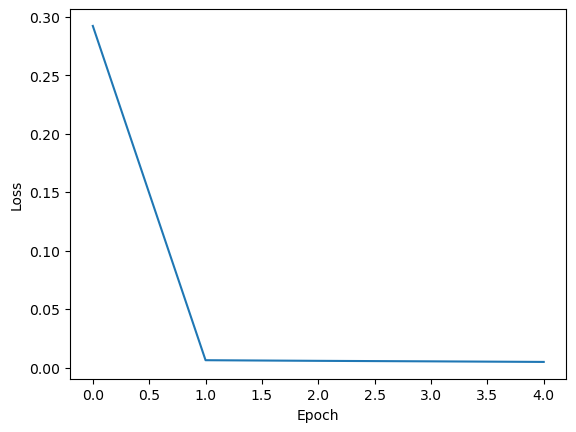

Training loss:  0.06285976042879832
------------------------------------------------------
( 2 ) - train with P = 12 ,H = 20 ,k = 1 ,lr = 0.01
Epoch:  0 , train loss: 0.7554484589737939
Epoch:  1 , train loss: 0.013045740785678125
Epoch:  2 , train loss: 0.009650748640384572
Epoch:  3 , train loss: 0.008121656584433196
Epoch:  4 , train loss: 0.0070125174799111276


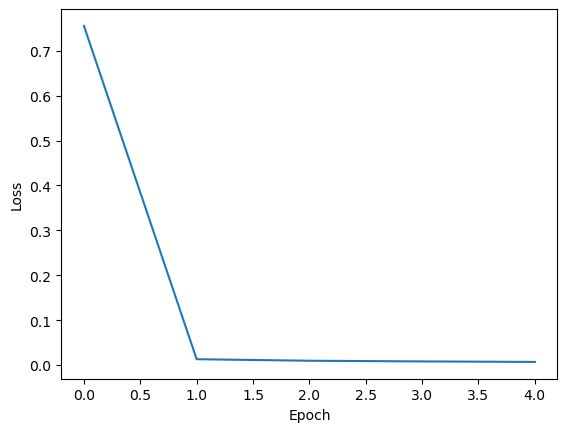

Training loss:  0.1586558244928402
------------------------------------------------------
( 3 ) - train with P = 16 ,H = 20 ,k = 1 ,lr = 0.01
Epoch:  0 , train loss: 1.2093688286686126
Epoch:  1 , train loss: 0.11408796297725537
Epoch:  2 , train loss: 0.016510173717519002
Epoch:  3 , train loss: 0.00688052704395972
Epoch:  4 , train loss: 0.0054493306372610665


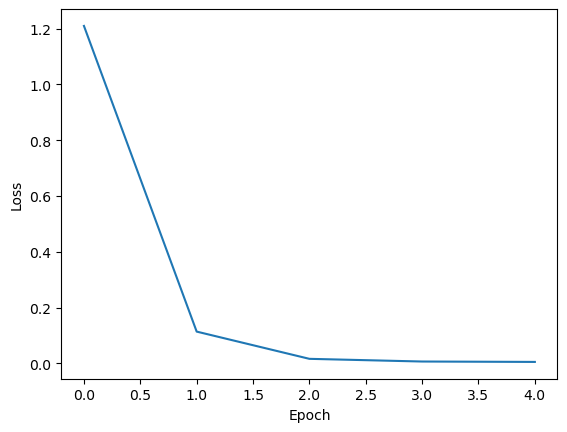

Training loss:  0.2704593646089216
------------------------------------------------------


AttributeError: 'RBM' object has no attribute 'H'

In [211]:
# uses the MSE loss for training
trained_models, train_params = train_model(x_train=x_train,
                                           x_test=x_test,
                                           ps=[8, 12, 16],
                                           hs=[20],
                                           ks=[1],
                                           lrs=[0.01],
                                           loss_fn=loss_functions['MSE'],
                                           max_epochs=5,
                                           patience=3,
                                           error_limit=1e-3,
                                           path="models/rbm/mse")

In [210]:
reconstruct_sample(x_test, 16, rbm_MSE_0, nr_samples, nr_patches)

NameError: name 'nr_samples' is not defined

In [ ]:
# increase the number of visible units
rbm_MSE_1 = RBM(P=16, H=20, k=1)
# training
rbm_mse_loss = rbm_MSE_1.fit(x_train,
                             lr=0.001,
                             loss_fn=loss_functions['MSE'],
                             epochs=50,
                             error_limit=1e-3,
                             patience=3)
print("rbm_MSE - Training loss: ", rbm_mse_loss)
reconstruct_sample(x_test, rbm_MSE_1, nr_samples, nr_patches)

In [ ]:
# increase the number of hidden units
rbm_MSE_2 = RBM(P=8, H=40, k=1)
# training
rbm_mse_loss = rbm_MSE_2.fit(x_train,
                             lr=0.001,
                             loss_fn=loss_functions['MSE'],
                             epochs=10,
                             error_limit=1e-3,
                             patience=3)
print("rbm_MSE - Training loss: ", rbm_mse_loss)
reconstruct_sample(x_test, rbm_MSE_2, nr_samples, nr_patches)

In [ ]:
# increase the nr of iterations in Gibbs sampling
rbm_MSE_2 = RBM(P=8, H=20, k=3)
# training
rbm_mse_loss = rbm_MSE_2.fit(x_train,
                             lr=0.001,
                             loss_fn=loss_functions['MSE'],
                             epochs=10,
                             error_limit=1e-3,
                             patience=3)
print("rbm_MSE - Training loss: ", rbm_mse_loss)
reconstruct_sample(x_test, rbm_MSE_2, nr_samples, nr_patches)

In [81]:
save_models([rbm_MSE_0, rbm_MSE_1, rbm_MSE_2], "models/rbm_mse")
models = load_models("models/rbm_mse")
for m in models:
    print(m.P)

Saved dataset configuration to file:  models/rbm_mse/model_0/nv
192


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 2. Model trained with Contrastive Divergence algorithm

In [44]:
# uses the contrastive Divergence alg for updating the weights and training the model
rbm_CD_0 = RBM(P=8, H=20, k=1)
# training
rbm_cd_loss = rbm_CD_0.fit(x_train,
                           lr=0.01,
                           batch_size=1,  # online training with batch size 1
                           loss_fn=loss_functions['CD'],
                           epochs=20,
                           patience=3)
print("rbm_CD - Training loss: ", rbm_cd_loss)
reconstruct_sample(x_test, rbm_CD_0, nr_samples, nr_patches)

Epoch:  0 , train loss: 14965.655972480774
Epoch:  1 , train loss: 13765.008926391602
Epoch:  2 , train loss: 14649.35196685791
Epoch:  3 , train loss: 14392.546123504639
Epoch:  4 , train loss: 13126.11192035675
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\keresztesbea\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2762, in while_loop
    loop_vars = body(*loop_vars)  File "C:\Users\keresztesbea\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2753, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "C:\Users\keresztesbea\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\map_fn.py", line 496, in compute
    return (i + 1, tas)  File "C:\Users\keresztesbea\anaconda3\envs\t

KeyboardInterrupt: 

In [ ]:
# uses the contrastive Divergence alg for updating the weights and training the model
rbm_CD_0 = RBM(P=8, H=20, k=1)
# training
rbm_cd_loss = rbm_CD_0.fit(x_train,
                           lr=0.01,
                           batch_size=1,  # online training with batch size 1
                           loss_fn=loss_functions['CD'],
                           epochs=20,
                           patience=3)
print("rbm_CD - Training loss: ", rbm_cd_loss)
reconstruct_sample(x_test, rbm_CD_0, nr_samples, nr_patches)

In [ ]:
# 3. Uses the Free energy value and the free-energy-gap for training
rbm_FE = RBM(P=ps, H=H, k=k)
#training
rbm_fe_loss = rbm_FE.fit(x_train, lr=LR, batch_size=BATCH_SIZE, loss_fn=loss_functions['FE'], epochs=EPOCHS,
                         patience=patience)
print("rbm_FE - Training loss: ", rbm_fe_loss)
reconstruct_sample(x_test, rbm_FE, 2, 2)

Epoch:  0 , train loss: 1.5396109521389008
Epoch:  1 , train loss: 1.5241750851273537
Epoch:  2 , train loss: 1.5082616955041885
Epoch:  3 , train loss: 1.4909131415188313
Epoch:  4 , train loss: 1.4735779538750648
Epoch:  5 , train loss: 1.4577698037028313
Epoch:  6 , train loss: 1.443474866449833
Epoch:  7 , train loss: 1.431727897375822
Epoch:  8 , train loss: 1.4220731481909752
Epoch:  9 , train loss: 1.4138397015631199


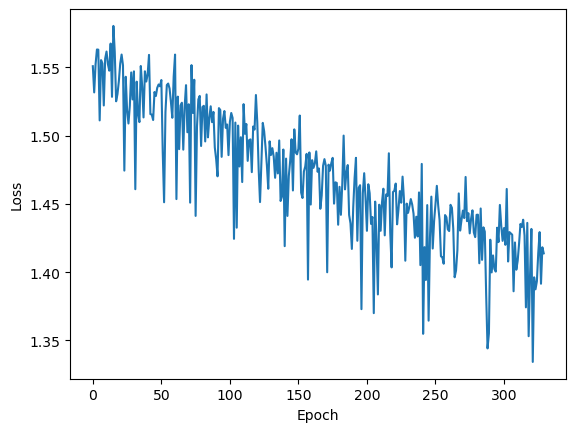

rbm_FE - Training loss:  1.470542424544692


In [300]:
# 4. Uses the cross-entropy loss for training
rbm_CRE = RBM(P=ps, H=H, k=k)
# training
rbm_cre_loss = rbm_CRE.fit(x_train, lr=LR, batch_size=BATCH_SIZE, loss_fn=loss_functions['CRE'], epochs=EPOCHS,
                           patience=patience)
print("rbm_CRE - Training loss: ", rbm_cre_loss)
reconstruct_sample(x_test, rbm_CRE, 2, 2)

## Evaluation Criteria

**Mean-squared Error (MSE)**: squared difference between the pixels of the original and reconstructed image

**Structural Similarity Index (SSIM)**: checks the image quality degradation, opposite to MSE, it looks for similarities between the pixel density values.

**Pixel-wise Detection Rate (PDR)**: ratio between the correctly detected pixels as obstacles (CDP) and the actual number of pixels belonging to obstacles (AP).
> PDR = CDP/AP

**Pixel-wise False-Positive Rate (PFPR)**: ratio between the nr of incorrectly detected pixels as obstacles (IDP) and the actual number of pixels belonging to obstacles (AP).
> PFPR = IDP/AP